**1 - LOAD PACKAGES**



*   [numpy](https://numpy.org/) is the fundamental package for scientific computing with Python.
*   [matplotlib](https://matplotlib.org/) is a library for plotting graphs in Python.
*   [pandas](https://pandas.pydata.org/) is used for data manipulation and analysis
*   [sklearn](https://scikit-learn.org/stable/) is used for data mining and data analysis using simple functions
*   [collections](https://docs.python.org/3/library/collections.html) is a library which implements operations on specialized container datatypes
*   [tensorflow](https://www.tensorflow.org/learn) is an open-source library used for high performance numerical computations and for building machine learning models





In [1]:
#Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import collections
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing, model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
import itertools

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization

**2 - LOADING THE DATA**

In [2]:
#Reading the data
with open('train.dat','r') as f:
    train = f.readlines()

with open('test.dat','r') as f:
    test = f.readlines()

**3 - UNDERSTANDING THE DATA**

In [3]:
#Splitting the data by tab
ytr = [int(p.split('\t')[0]) for p in train]
tr = [p.split('\t')[1].strip() for p in train]
tr_label = [p.split('\t')[0].strip() for p in train]
tr_label = np.array(tr_label).astype(int)

# te = [int(p.split('\t')[0]) for p in test]
te = [p.strip() for p in test]

In [4]:
len_train = len(train)
len_test = len(test)
label_count = Counter(tr_label)

print (f'The shape of train data is: ',  len_train)
print (f'The shape of test data is: ', len_test)
print (f'Label count: ', label_count)

The shape of train data is:  1566
The shape of test data is:  392
Label count:  Counter({-1: 1424, 1: 142})


**4 - PREPROCESSING THE DATA**

Feature exraction has been done using the k-mers model and obersampling has been done using RandomOverSampler in-built function of imblearn library in python.

**4.1 - Extracting character sequences using k-mers**

In [5]:
#k mers generates all possible substrings of length k
def kmer(p, k =2):
  return [p[i:i+k] for i in range(0,len(p) - k+1)]

def kmers(p, k =2):
  els = []
  for i in range(1,k):
    els.extend(kmer(p, k =i))
  return els

tr = [kmers(p, k=3) for p in tr]
te = [kmers(p, k=3) for p in te]

mp = {}
for p in tr+te:
  for e in p:
    if e not in mp:
      mp[e] = len(mp.keys()) #assigning it the length of the dictionary
len(mp)

436

In [6]:
#Making a dense matrix
def dense(ds):
  op = []
  for p in ds:
    res = [0] * len(mp)
    count = dict(collections.Counter(p))
    for k in count:
      res[mp[k]] = count[k]
    op.append(res)
  return np.array(op)

In [7]:
dense_mat_train = dense(tr)
dense_mat_test = dense(te)

**4.2 - Oversampling to balance the data**

In [8]:
# Doing oversampling to balance the imbalanced classes
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
train_bal_df, train_bal_y = oversampler.fit_resample(dense_mat_train, tr_label)

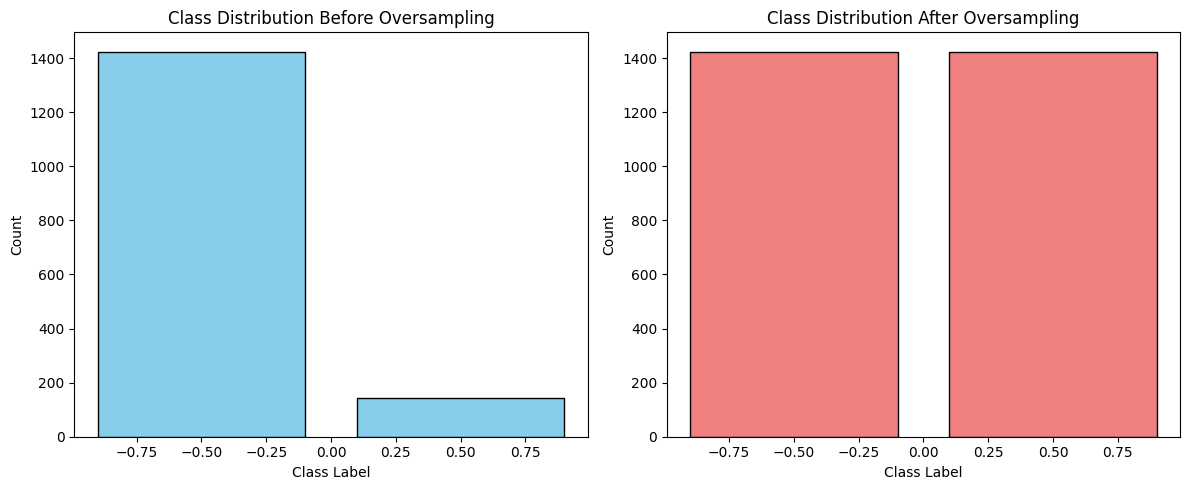

In [9]:
# Plotting class distribution before oversampling
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(tr_label, bins = (-1,0,1), rwidth=0.8, color='skyblue', edgecolor='black')
plt.title('Class Distribution Before Oversampling')
plt.xlabel('Class Label')
plt.ylabel('Count')

# Plotting class distribution after oversampling
plt.subplot(1, 2, 2)
plt.hist(train_bal_y, bins = (-1,0,1), rwidth=0.8, color='lightcoral', edgecolor='black')
plt.title('Class Distribution After Oversampling')
plt.xlabel('Class Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

**4.3 - Splitting data into train and validation sets to start training**

In [10]:
#dividing data into training and test
train_x, val_x, train_y, val_y = model_selection.train_test_split(train_bal_df, train_bal_y, test_size = 0.2, random_state = 42)

**5 - TENSORFLOW MODEL ARCHITECTURE**

**5.1 Building the model**

In [11]:
# Creating the peptide classification model
def peptide_classification_model(kmers, x):
    model = models.Sequential()

    # Adding a Dense layer with ReLU activation as the first hidden layer
    model = Sequential()
    # model.add(Embedding(input_dim=len(kmers), output_dim=32, input_length=x.shape[1]))
    # model.add(LSTM(32))

    # Adding a Dense layer with ReLU activation
    model.add(layers.Dense(256, activation='relu', input_shape=(x.shape[1],), kernel_regularizer=l2(0.001)))

    #Adding a dropout layer
    model.add(Dropout(0.8))

    # Adding another Dense layer with ReLU activation
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)))

    # Adding a batch normalization layer
    model.add(BatchNormalization())

    # Adding the output layer with sigmoid activation for binary classification
    model.add(layers.Dense(1, activation='sigmoid'))

    #Defining the optimizer
    adam = Adam(learning_rate=0.0001)
    # Compiling the model
    model.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Inputting the number of features
kmers = mp
x = train_bal_df

# Creating the binary classification model
binary_model = peptide_classification_model(kmers, x)

# Model summary
binary_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               111872    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 145409 (568.00 KB)
Trainable params: 145153 (567.00 KB)
Non-trainable params: 256 (1.00 KB)
______________

In [12]:
train_bal_df.shape

(2848, 436)

**5.2 - Defining the hyperparameters and training the model**

In [13]:
# Training the model
history = binary_model.fit(train_x, train_y, epochs=100, validation_data=(val_x, val_y))

Epoch 1/100
72/72 [==============================] - 1s 6ms/step - loss: 1.0664 - accuracy: 0.2928 - val_loss: 0.5864 - val_accuracy: 0.2649
Epoch 2/100
72/72 [==============================] - 0s 3ms/step - loss: 0.4678 - accuracy: 0.3696 - val_loss: 0.1001 - val_accuracy: 0.3947
Epoch 3/100
72/72 [==============================] - 0s 3ms/step - loss: -0.0512 - accuracy: 0.4008 - val_loss: -0.4606 - val_accuracy: 0.4105
Epoch 4/100
72/72 [==============================] - 0s 4ms/step - loss: -0.5989 - accuracy: 0.4096 - val_loss: -1.1164 - val_accuracy: 0.4158
Epoch 5/100
72/72 [==============================] - 0s 4ms/step - loss: -1.2233 - accuracy: 0.4271 - val_loss: -1.8447 - val_accuracy: 0.4211
Epoch 6/100
72/72 [==============================] - 0s 4ms/step - loss: -1.9198 - accuracy: 0.4346 - val_loss: -2.6773 - val_accuracy: 0.4211
Epoch 7/100
72/72 [==============================] - 0s 4ms/step - loss: -2.6929 - accuracy: 0.4403 - val_loss: -3.6474 - val_accuracy: 0.4228
Epo

**6 - Model Evaluation**

**6.1 - Checking the loss curve for train and validation data**

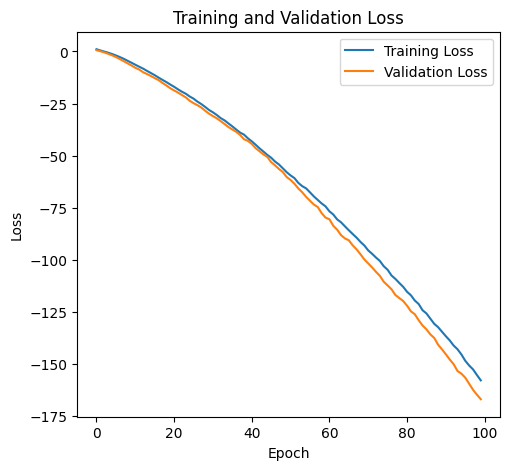

In [20]:
# Plotting the loss curve
plt.figure(figsize=(12, 5))

# Plotting the training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [15]:
train_predictions = binary_model.predict(train_x)
val_predictions = binary_model.predict(val_x)

18/18 [==============================] - 0s 1ms/step


In [16]:
pred_val_y= (binary_model.predict(train_x) > 0.5).astype(int)
mcc = matthews_corrcoef(train_y, pred_val_y)
print(f'Matthews Correlation Coefficient on validation set: {mcc}')

72/72 [==============================] - 0s 1ms/step
Matthews Correlation Coefficient on validation set: 0.5


**6.2 - Building a Confusion Matrix**

In [17]:
def plotCf(a,b,t):
    cf = confusion_matrix(a, b)
    plt.imshow(cf, cmap = plt.cm.Blues, interpolation = 'nearest')
    plt.colorbar()
    plt.title(t)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(a))) # length of classes
    class_labels = ['0','1']
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    thresh = cf.max() / 2.
    for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
        plt.text(j, i, format(cf[i,j],'d'), horizontalalignment = 'center', color = 'white' if cf[i,j] >thresh else 'black')
    plt.show()

<ipython-input-18-e81eeee8b2b9>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  target = np.around(np.squeeze(train_y), decimals = 0).astype(np.int)
<ipython-input-18-e81eeee8b2b9>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informatio

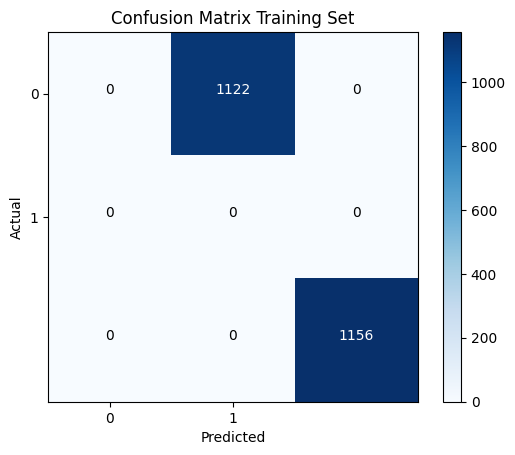

<ipython-input-18-e81eeee8b2b9>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  target = np.around(np.squeeze(val_y), decimals = 0).astype(np.int)
<ipython-input-18-e81eeee8b2b9>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.

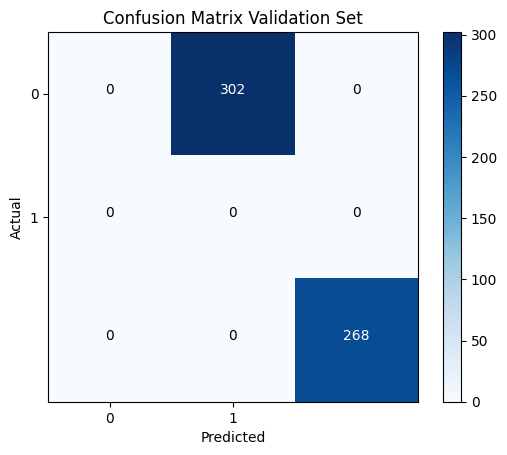

In [18]:
X, Y = train_x, train_y
target = np.around(np.squeeze(train_y), decimals = 0).astype(np.int)
predicted = np.around(np.squeeze(train_predictions), decimals = 0).astype(np.int)
plotCf(target, predicted, 'Confusion Matrix Training Set')

X, Y = val_x, val_y
target = np.around(np.squeeze(val_y), decimals = 0).astype(np.int)
predicted = np.around(np.squeeze(val_predictions), decimals = 0).astype(np.int)
plotCf(target, predicted, 'Confusion Matrix Validation Set')

**7 - MAKING PREDICTIONS FOR THE TEST FILE**

In [23]:
predictions_test = (binary_model.predict(dense_mat_test) > 0.5).astype(int)

13/13 [==============================] - 0s 2ms/step


In [24]:
predictions_test = np.where(predictions_test == 0, -1, predictions_test)

In [25]:
predictions_test

array([[-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],